### Initial Setup

Installations, imports, helper functions

In [ ]:
# installs
%%capture

!pip install openai
!pip install transformers
!pip install sentence-transformers

In [ ]:
# imports
import numpy as np
import pandas as pd
import time
import torch
import tqdm
from sentence_transformers import SentenceTransformer, util
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# upload external file before import
from google.colab import files

import openai
import os
openai.api_key = ""
# os.getenv("OPENAI_API_KEY")

In [ ]:
# Helper functions

def raw_predict(prompt, model = 'text-davinci-002'):
    response = openai.Completion.create(
            model= model, #"text-davinci-002",
            prompt=prompt,
            temperature=0.6,
            max_tokens = 200
        )
    result = response.choices[0].text
    return result

device = torch.device('cuda')

# sentence transformer to compute accuracy between predictions.
sbert_large = SentenceTransformer('sentence-transformers/all-mpnet-base-v2').to(device = device)
def cosine_sim(trues, preds):
    # example:
    # embeddings = sbert.encode(["Walk to home office", "Walk to desk"])
    embeddings_trues = sbert_large.encode(trues)#.cpu()
    embeddings_preds = sbert_large.encode(preds)#.cpu()
    cosine_scores = util.cos_sim(embeddings_trues, embeddings_preds)
    return cosine_scores

# def cosine_sim(trues, preds):
#     sbert = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
#     # example:
#     # embeddings = sbert.encode(["Walk to home office", "Walk to desk"])
#     embeddings_trues = sbert.encode(trues)
#     embeddings_preds = sbert.encode(preds)
#     cosine_scores = util.cos_sim(embeddings_trues, embeddings_preds)
#     return cosine_scores

sbert_small = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2').to(device = device) #all-mpnet-base-v2
def cluster(examples, threshold = 0.9, min_cluster_size = 5):
    embeddings = sbert_small.encode(examples, batch_size=64, show_progress_bar=False, convert_to_tensor=True)#.cpu()
    clusters = util.community_detection(embeddings, min_community_size=min_cluster_size, threshold=threshold)
    return clusters, embeddings

# def cluster(examples, threshold = 0.9, min_cluster_size = 5):
#     sbert = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2') #all-mpnet-base-v2
#     embeddings = sbert.encode(examples, batch_size=64, show_progress_bar=True, convert_to_tensor=True)
#     clusters = util.community_detection(embeddings, min_community_size=min_cluster_size, threshold=threshold)
#     return clusters, embeddings

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [ ]:
# Mount drive to pull the data folder.
from google.colab import drive
drive.mount('/content/drive')
prefix = '/content/drive/MyDrive/fsl-sequential-data-folder'

Mounted at /content/drive


In [ ]:
train_data = pd.Series(open(prefix + '/virtual_home_train_prompt.txt').readlines())
val_data = pd.Series(open(prefix + '/virtual_home_validation_prompt.txt').readlines())
test_data = pd.Series(open(prefix + '/virtual_home_test_prompt.txt').readlines())
print(f'Total Data points: TRAIN {len(train_data)} | EVAL {len(val_data)} | TEST {len(test_data)}')

Total Data points: TRAIN 3052 | EVAL 1016 | TEST 1018


# Experiments

## GPT-2 Finetuning on the Dataset

In [ ]:
finetune_clusters, embeddings = cluster(train_data, min_cluster_size = 10, threshold = 0.90)
finetune_centroids = torch.stack([torch.mean(embeddings[cluster], axis = 0) for cluster in finetune_clusters])
len(finetune_clusters), len(train_data)

(66, 3052)

In [ ]:
import os
import time
import datetime
from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# GPT2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2') #gpt2-medium # dont set any bos/eos/pad tokens.
tokenizer.pad_token = tokenizer.eos_token
tokenizer

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

PreTrainedTokenizer(name_or_path='gpt2', vocab_size=50257, model_max_len=1024, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pad_token': '<|endoftext|>'})

In [ ]:
# init model
model = GPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id).to(device) # keep the model unaware of pad tokens. let it be eos tokens.
# model.resize_token_embeddings(len(tokenizer))

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

**Sample outputs to begin with**

In [ ]:
sample_outputs = model.generate(
                    tokenizer(tokenizer.bos_token + " Walk to office =>", return_tensors = 'pt')['input_ids'].to(device),
                    do_sample=True,   
                    top_k=50, 
                    max_length = 200,
                    top_p=0.95)
print(tokenizer.decode(sample_outputs[0], skip_special_tokens=True))

 Walk to office => go to office or send an email

Washroom Store

Washroom is a new online store for all sorts of cleaning products and grooming products. The website also features a collection of great things to buy and sell at the washroom. Washing is a good way of getting out of the messy house and clean up your household and you should check it out.

Get more personal info »

What's Next

Wearing clothes everyday is going to be a lot easier than you think, so you should invest in more comfort, comfort clothes. Your clothing choices will reflect what your needs are, so you'll want a pair of smart shoes that suit you well. When you want to stay well, your clothes may be worth more than the cost of clothes, and they will make you look professional by providing a comfortable, comfortable interior and a comfortable wardrobe.


Works!!

In [ ]:
!nvidia-smi

Mon Dec  5 21:13:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    31W /  70W |   2176MiB / 15109MiB |     38%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Data setup

In [ ]:
def generate_similar_support_set(query, clusters, centroids, n_examples = 15, printf = False):
  embeddings = sbert_small.encode(query, batch_size=64, show_progress_bar=False, convert_to_tensor=True)#.cpu()
  
  pick_cluster = torch.argmax(torch.tensordot(centroids, embeddings.unsqueeze(dim = 1), dims = 1).squeeze(), axis = 0).item()

  indices = np.random.choice(clusters[pick_cluster], size = n_examples)
  support_set = train_data.iloc[indices].tolist()
  
  if printf:
    for i, s in enumerate(support_set):
      if i > 5: break
      print(support_set[i])
  return support_set

query = "Walk to home office=>Walk to desk=>Find chair=>Pull chair=>Sit on chair=>Find computer=>Switch on computer=>Find mouse=>Grab mouse=>Find keyboard=>Type on keyboard"
support_set = generate_similar_support_set(query, finetune_clusters, finetune_centroids, printf = True)

Walk to bedroom=>Walk to computer=>Find computer=>Find chair=>Sit on chair=>Switch on computer=>Find keyboard=>Type on keyboard

Walk to home office=>Walk to chair=>Find chair=>Sit on chair=>Find laptop=>Pull laptop=>Switch on laptop=>Turn to laptop=>Look at laptop=>Find keyboard=>Type on keyboard

Walk to home office=>Walk to chair=>Find chair=>Sit on chair=>Find computer=>Switch on computer=>Turn to computer=>Look at computer=>Find mail=>Grab mail=>Read mail

Walk to home office=>Walk to desk=>Find chair=>Sit on chair=>Find computer=>Switch on computer=>Turn to computer=>Look at computer=>Find mouse=>Touch mouse=>Find keyboard=>Type on keyboard=>Turn to computer=>Look at computer

Walk to home office=>Walk to computer=>Find computer=>Turn to computer=>Look at computer=>Find chair=>Sit on chair=>Switch on computer=>Find keyboard=>Type on keyboard=>Switch off computer

Find computer=>Find chair=>Turn to chair=>Look at chair=>Turn to chair=>Walk to chair=>Pull chair=>Sit on chair=>Find 

In [ ]:
def generate_training_set(cluster_id, clusters, centroids, n_examples = 15, printf = False):
  indices = np.random.choice(clusters[cluster_id], size = n_examples)
  support_set = train_data.iloc[indices].tolist()

  if printf:
    for i, s in enumerate(support_set):
      if i > 5: break
      print(support_set[i])
  return support_set

In [ ]:
max_length = 768

class GPT2Dataset(Dataset):
  def __init__(self, tokenizer, train, clusters = None, centroids = None, val_data = None, gpt2_type="gpt2", max_length=768):
    self.tokenizer = tokenizer
    self.train = train
    self.val_data = val_data
    self.clusters = clusters
    self.centroids = centroids

  def __len__(self):
    if self.train:
      return len(self.clusters)
    else:
      return len(self.val_data)

  def __getitem__(self, idx):
    cluster_id = np.random.choice(len(self.clusters))

    n_examples = 25
    
    while True:
      if self.train:
        support_examples = generate_training_set(cluster_id, self.clusters, self.centroids, n_examples = n_examples)
      else:
        support_examples = generate_similar_support_set(self.val_data[idx], self.clusters, self.centroids, n_examples = n_examples, printf = False)
      
      prompt = self.tokenizer.bos_token
      query_tokens_length = ''
      for i, example in enumerate(support_examples):
        example_text = example.strip() # '<|startoftext|>'+ example.strip() + '<|endoftext|>'
        if i != len(support_examples)-1:
          example_text += '\n'
        else:
          example_text += self.tokenizer.eos_token
        prompt += example_text
        query_tokens_length = len(self.tokenizer(example_text, truncation = False)['input_ids'])
      
      if len(tokenizer(prompt, truncation = False)['input_ids']) < max_length: 
        break

      n_examples -=1

    encodings_dict = self.tokenizer(prompt, truncation=True, max_length=max_length, padding="max_length")

    input_ids = torch.tensor(encodings_dict['input_ids'], device = device)
    attn_masks = torch.tensor(encodings_dict['attention_mask'], device = device)
    loss_masks = torch.tensor([0.] * (attn_masks.sum() - query_tokens_length) + [1.] * query_tokens_length + [0.] * (len(attn_masks) - attn_masks.sum()), device = device)

    return input_ids, attn_masks, loss_masks

Number of Examples in my clusters

**Training dataset**

Prepared by randomly sampling a cluster ID and then picking some examples that can fit into max size of 768 tokens.

In [ ]:
train_dataset = GPT2Dataset(tokenizer, train = True, clusters = finetune_clusters, centroids = finetune_centroids)
input_ids, attn_masks, loss_masks = train_dataset[0]
print(tokenizer.decode(input_ids))

<|endoftext|>Find cat=>Walk to cat=>Turn to cat=>Look at cat=>Touch cat=>Scrub cat
Find cat=>Turn to cat=>Look at cat=>Touch cat
Find cat=>Touch cat
Find cat=>Turn to cat=>Look at cat=>Touch cat
Find cat=>Touch cat
Find cat=>Turn to cat=>Look at cat=>Touch cat
Find cat=>Turn to cat=>Look at cat=>Walk to cat=>Touch cat
Find cat=>Turn to cat=>Look at cat=>Touch cat
Find cat=>Touch cat
Find cat=>Turn to cat=>Look at cat=>Touch cat=>Touch cat
Find cat=>Touch cat
Find cat=>Touch cat
Find cat=>Turn to cat=>Look at cat=>Walk to cat=>Touch cat
Find cat=>Touch cat
Find cat=>Touch cat
Find cat=>Touch cat=>Touch cat
Find cat=>Touch cat
Find cat=>Touch cat
Find cat=>Turn to cat=>Look at cat=>Find face=>Touch face
Find cat=>Touch cat
Find cat=>Touch cat
Find cat=>Turn to cat=>Look at cat=>Walk to cat=>Touch cat
Find cat=>Touch cat
Find cat=>Touch cat=>Touch cat
Find cat=>Walk to cat=>Turn to cat=>Look at cat=>Touch cat=>Scrub cat<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|end

In [ ]:
tokenizer.decode(input_ids[loss_masks==1])

' floor lamp=>Find floor lamp=>Turn to floor lamp=>Switch on floor lamp=>Find bed=>Lie on'

Token indices sequence length is longer than the specified maximum sequence length for this model (1332 > 1024). Running this sequence through the model will result in indexing errors
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


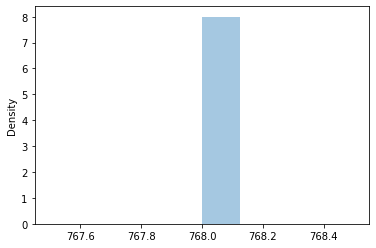

In [ ]:
doc_lengths = []

for i in range(len(finetune_clusters)):
    input_ids, attn_masks, loss_masks = train_dataset[i]

    # prompt_text = tokenizer.decode(input_ids)

    # get rough token count distribution
    # tokens = nltk.word_tokenize(prompt_text)

    doc_lengths.append(len(input_ids))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [ ]:
# the max token length   
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

0.0

**Validation dataset**

Go through the validation set query and match them with similar training examples. Obtain each data instance as prompt of that query alongwith examples from training set.

In [ ]:
val_dataset = GPT2Dataset(tokenizer, train = False, val_data = val_data, clusters = finetune_clusters, centroids = finetune_centroids)
input_ids, attn_masks, val_loss_masks = val_dataset[0]
print(tokenizer.decode(input_ids))

<|endoftext|>Walk to bedroom=>Walk to floor lamp=>Find floor lamp=>Turn to floor lamp=>Switch on floor lamp=>Find bed=>Lie on bed
Walk to bedroom=>Walk to floor lamp=>Find floor lamp=>Turn to floor lamp=>Switch on floor lamp=>Find bed=>Lie on bed
Walk to bedroom=>Walk to floor lamp=>Find floor lamp=>Turn to floor lamp=>Switch on floor lamp=>Find bed=>Lie on bed
Walk to bedroom=>Walk to floor lamp=>Switch off floor lamp
Walk to bedroom=>Walk to floor lamp=>Find floor lamp=>Turn to floor lamp=>Switch on floor lamp=>Find bed=>Lie on bed
Walk to bedroom=>Walk to floor lamp=>Switch off floor lamp
Walk to bedroom=>Walk to floor lamp=>Switch off floor lamp
Walk to bedroom=>Walk to floor lamp=>Find floor lamp=>Turn to floor lamp=>Switch on floor lamp=>Find bed=>Lie on bed
Walk to bedroom=>Walk to floor lamp=>Switch off floor lamp
Walk to bedroom=>Walk to floor lamp=>Switch off floor lamp
Walk to bedroom=>Walk to floor lamp=>Find floor lamp=>Turn to floor lamp=>Switch on floor lamp=>Find bed=>L

#### Dataloaders

In [ ]:
print('{:>5,} training samples'.format(len(train_dataset)))
print('{:>5,} validation samples'.format(len(val_dataset)))

batch_size = 2
val_batch_size = 10
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

   66 training samples
1,016 validation samples


In [ ]:
next(iter(train_dataloader))[0].device

Token indices sequence length is longer than the specified maximum sequence length for this model (1037 > 1024). Running this sequence through the model will result in indexing errors


device(type='cuda', index=0)

**Fine-tuning GPT2**

### Model configuration

Reference [notebook](https://colab.research.google.com/drive/13dZVYEOMhXhkXWfvSMVM1TTtUDrT6Aeh#scrollTo=D6TKgyUzPIQc)

In [ ]:
# # I'm not really doing anything with the config buheret
# configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# # instantiate the model
# model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# # this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# # otherwise the tokenizer and model tensors won't match up
# # model.resize_token_embeddings(len(tokenizer))

# # Tell pytorch to run this model on the GPU.
# device = torch.device("cuda")
# model.cuda()

### Linear Probing/Finetuning

In [ ]:
lp = True
file_name = prefix + '/vh_lp_dec2.pth'

In [ ]:
for p in model.parameters(): p.requires_grad_(not lp)
# only turn on linear probing for the LM head.
for p in model.lm_head.parameters(): p.requires_grad_(True)

### Initialize parameters

In [ ]:
# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# some parameters I cooked up that work reasonably well

epochs = 40
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 20

epoch_start = 0
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

if Path(file_name).exists():
  dict_ = torch.load(file_name)
  epoch_start = dict_['epoch']
  model.load_state_dict(dict_['model'])
  optimizer.load_state_dict(dict_['optimizer'])
  scheduler.load_state_dict(dict_['scheduler'])

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [ ]:
file_name

'/content/drive/MyDrive/fsl-sequential-data-folder/vh_lp_dec2.pth'

In [ ]:
!nvidia-smi

Thu Dec 15 04:37:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    29W /  70W |  10916MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### **Training**

In [ ]:
model = model.to(device)

Sanity tests ahead of the real one.

In [ ]:
batch = next(iter(train_dataloader))

b_input_ids = batch[0].to(device)
b_labels = torch.clone(batch[0]).to(device)
b_masks = batch[1].to(device)
b_loss_masks = batch[2].to(device)

b_labels[b_loss_masks==0] = -100

outputs = model(b_input_ids,
                labels=b_labels, 
                attention_mask = b_masks,
                token_type_ids=None
              )

All set !

In [ ]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

accumulation_steps = 2

for epoch_i in range(epoch_start, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0
    train_nlls = []
    train_tokens_len = []
    
    for step, batch in enumerate(train_dataloader):
        model.train()
        model.zero_grad()

        b_input_ids = batch[0].to(device)
        b_labels = torch.clone(batch[0]).to(device)
        b_masks = batch[1].to(device)
        b_loss_masks = batch[2].to(device)

        # b_labels[b_loss_masks==0] = -100


        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )
        
        loss = outputs[0]
        batch_loss = loss.item()
        total_train_loss += batch_loss

        tokens_len = b_loss_masks.sum()
        neg_log_likelihood = batch_loss * tokens_len
        train_nlls.append(neg_log_likelihood)
        train_tokens_len.append(tokens_len)
    
        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                tokenizer(tokenizer.bos_token + " Walk to office =>", return_tensors = 'pt')['input_ids'].to(device),
                                do_sample=True,   
                                temperature = 0.6,
                                no_repeat_ngram_size=2,
                                top_k=50, 
                                max_length = 50,
                                top_p=0.95,
                                num_return_sequences = 1
                              )
            
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)
    
    # Train perplexity
    train_pp = torch.exp(torch.stack(train_nlls).sum() / sum(train_tokens_len)).item()
    
    # Measure how long this epoch took.
    training_time_taken = time.time() - t0
    training_time = format_time(training_time_taken)

    print("")
    print("  Average training loss: {:.2f} Perplexity: {:.2f}".format(avg_train_loss, train_pp))
    print("  Training epoch took: {:}".format(training_time))

    # continue
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0
    val_loss = 0

    # Evaluate data for one epoch
    val_nlls = []
    val_tokens_len = []
    for batch in tqdm.tqdm(validation_dataloader, total = len(validation_dataloader)):
        b_input_ids = batch[0].to(device)
        b_labels = torch.clone(batch[0]).to(device)
        b_masks = batch[1].to(device)
        b_loss_masks = batch[2].to(device)

        # b_labels[b_loss_masks==0] = -100
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
                          #  token_type_ids=None, 
                             attention_mask = b_masks,
                             labels=b_labels)
          
            loss = outputs[0]  
        
        batch_loss = loss.item()
        total_eval_loss += batch_loss  

        tokens_len = b_loss_masks.sum()
        neg_log_likelihood = batch_loss * tokens_len
        val_nlls.append(neg_log_likelihood)
        val_tokens_len.append(tokens_len)

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    val_pp = torch.exp(torch.stack(val_nlls).sum() / sum(val_tokens_len)).item()
    validation_time_taken = time.time() - t0
    validation_time = format_time(validation_time_taken)

    print("  Validation Loss: {:.2f} Perplexity: {:.2f}".format(avg_val_loss, val_pp))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append({
      'training_loss': avg_train_loss,
      'training_perplexity': train_pp,
      'validation_loss': avg_val_loss,
      'validation_perplexity': val_pp,
      'training_time': training_time_taken,
      'validation_time': validation_time_taken
    })

    result = {
      'epoch': epoch_i + 1,
      'training_stats': training_stats,
      'model': model.state_dict(),
      'optimizer': optimizer.state_dict(),
      'scheduler': scheduler.state_dict()
    }

    torch.save(result, file_name)

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 40 ========
Training...
  Batch    20  of     33. Loss: 2.139601945877075.   Elapsed: 0:00:10.
0:  Walk to office =>

A. Walk through the office
.
 (This is the home office of the president.)
-1-
P. Move your desk to the right
(This office is in the front row.) (

  Average training loss: 2.51 Perplexity: 9.49
  Training epoch took: 0:00:16

Running Validation...


100%|██████████| 508/508 [03:43<00:00,  2.27it/s]


  Validation Loss: 2.14 Perplexity: 7.34
  Validation took: 0:03:43

======== Epoch 2 / 40 ========
Training...
  Batch    20  of     33. Loss: 1.3157843351364136.   Elapsed: 0:00:10.
0:  Walk to office => office phone

  Average training loss: 1.75 Perplexity: 4.84
  Training epoch took: 0:00:16

Running Validation...


100%|██████████| 508/508 [03:49<00:00,  2.22it/s]


  Validation Loss: 1.15 Perplexity: 3.09
  Validation took: 0:03:49

======== Epoch 3 / 40 ========
Training...
  Batch    20  of     33. Loss: 1.1074267625808716.   Elapsed: 0:00:10.
0:  Walk to office =>

  Average training loss: 0.95 Perplexity: 2.65
  Training epoch took: 0:00:16

Running Validation...


100%|██████████| 508/508 [04:21<00:00,  1.94it/s]


  Validation Loss: 0.70 Perplexity: 2.08
  Validation took: 0:04:22

======== Epoch 4 / 40 ========
Training...
  Batch    20  of     33. Loss: 0.7515935301780701.   Elapsed: 0:00:11.
0:  Walk to office =>

  Average training loss: 0.73 Perplexity: 2.19
  Training epoch took: 0:00:18

Running Validation...


100%|██████████| 508/508 [03:49<00:00,  2.22it/s]


  Validation Loss: 0.64 Perplexity: 1.95
  Validation took: 0:03:49

======== Epoch 5 / 40 ========
Training...
  Batch    20  of     33. Loss: 0.5300979018211365.   Elapsed: 0:00:10.
0:  Walk to office =>

  Average training loss: 0.67 Perplexity: 2.01
  Training epoch took: 0:00:17

Running Validation...


100%|██████████| 508/508 [03:44<00:00,  2.26it/s]


  Validation Loss: 0.59 Perplexity: 1.85
  Validation took: 0:03:45

======== Epoch 6 / 40 ========
Training...
  Batch    20  of     33. Loss: 0.7458709478378296.   Elapsed: 0:00:10.
0:  Walk to office =>

  Average training loss: 0.64 Perplexity: 2.03
  Training epoch took: 0:00:17

Running Validation...


100%|██████████| 508/508 [03:40<00:00,  2.30it/s]


  Validation Loss: 0.56 Perplexity: 1.81
  Validation took: 0:03:41

======== Epoch 7 / 40 ========
Training...
  Batch    20  of     33. Loss: 0.48135361075401306.   Elapsed: 0:00:10.
0:  Walk to office => office


  Average training loss: 0.54 Perplexity: 1.79
  Training epoch took: 0:00:16

Running Validation...


100%|██████████| 508/508 [03:41<00:00,  2.30it/s]


  Validation Loss: 0.54 Perplexity: 1.77
  Validation took: 0:03:41

======== Epoch 8 / 40 ========
Training...
  Batch    20  of     33. Loss: 0.5018577575683594.   Elapsed: 0:00:11.
0:  Walk to office => office


  Average training loss: 0.55 Perplexity: 1.86
  Training epoch took: 0:00:17

Running Validation...


100%|██████████| 508/508 [03:40<00:00,  2.30it/s]


  Validation Loss: 0.53 Perplexity: 1.75
  Validation took: 0:03:41

======== Epoch 9 / 40 ========
Training...
  Batch    20  of     33. Loss: 0.6895571351051331.   Elapsed: 0:00:11.
0:  Walk to office => office office

  Average training loss: 0.49 Perplexity: 1.71
  Training epoch took: 0:00:17

Running Validation...


100%|██████████| 508/508 [03:39<00:00,  2.31it/s]


  Validation Loss: 0.53 Perplexity: 1.74
  Validation took: 0:03:39

======== Epoch 10 / 40 ========
Training...
  Batch    20  of     33. Loss: 0.4869315028190613.   Elapsed: 0:00:10.
0:  Walk to office =>


  Average training loss: 0.49 Perplexity: 1.70
  Training epoch took: 0:00:16

Running Validation...


100%|██████████| 508/508 [03:42<00:00,  2.28it/s]


  Validation Loss: 0.51 Perplexity: 1.70
  Validation took: 0:03:42

======== Epoch 11 / 40 ========
Training...
  Batch    20  of     33. Loss: 0.5703003406524658.   Elapsed: 0:00:11.
0:  Walk to office =>
Walk to chair


  Average training loss: 0.54 Perplexity: 1.80
  Training epoch took: 0:00:17

Running Validation...


100%|██████████| 508/508 [03:39<00:00,  2.31it/s]


  Validation Loss: 0.49 Perplexity: 1.68
  Validation took: 0:03:40

======== Epoch 12 / 40 ========
Training...
  Batch    20  of     33. Loss: 0.5715028643608093.   Elapsed: 0:00:10.
0:  Walk to office => phone office


  Average training loss: 0.47 Perplexity: 1.64
  Training epoch took: 0:00:16

Running Validation...


100%|██████████| 508/508 [03:39<00:00,  2.31it/s]


  Validation Loss: 0.47 Perplexity: 1.65
  Validation took: 0:03:40

======== Epoch 13 / 40 ========
Training...
  Batch    20  of     33. Loss: 0.41205111145973206.   Elapsed: 0:00:10.
0:  Walk to office =>

  Average training loss: 0.47 Perplexity: 1.69
  Training epoch took: 0:00:17

Running Validation...


100%|██████████| 508/508 [03:39<00:00,  2.31it/s]


  Validation Loss: 0.47 Perplexity: 1.64
  Validation took: 0:03:40

======== Epoch 14 / 40 ========
Training...
  Batch    20  of     33. Loss: 0.4694839417934418.   Elapsed: 0:00:10.
0:  Walk to office => phone

  Average training loss: 0.47 Perplexity: 1.67
  Training epoch took: 0:00:17

Running Validation...


100%|██████████| 508/508 [03:41<00:00,  2.29it/s]


  Validation Loss: 0.46 Perplexity: 1.62
  Validation took: 0:03:42

======== Epoch 15 / 40 ========
Training...
  Batch    20  of     33. Loss: 0.5429689288139343.   Elapsed: 0:00:11.
0:  Walk to office =>


  Average training loss: 0.46 Perplexity: 1.62
  Training epoch took: 0:00:17

Running Validation...


100%|██████████| 508/508 [03:38<00:00,  2.32it/s]


  Validation Loss: 0.46 Perplexity: 1.62
  Validation took: 0:03:39

======== Epoch 16 / 40 ========
Training...
  Batch    20  of     33. Loss: 0.39487481117248535.   Elapsed: 0:00:10.
0:  Walk to office => office
Walk to desk=> office

  Average training loss: 0.45 Perplexity: 1.62
  Training epoch took: 0:00:16

Running Validation...


100%|██████████| 508/508 [03:38<00:00,  2.32it/s]


  Validation Loss: 0.45 Perplexity: 1.61
  Validation took: 0:03:39

======== Epoch 17 / 40 ========
Training...
  Batch    20  of     33. Loss: 0.5486582517623901.   Elapsed: 0:00:10.
0:  Walk to office =>

  Average training loss: 0.43 Perplexity: 1.59
  Training epoch took: 0:00:16

Running Validation...


100%|██████████| 508/508 [03:39<00:00,  2.32it/s]


  Validation Loss: 0.45 Perplexity: 1.60
  Validation took: 0:03:39

======== Epoch 18 / 40 ========
Training...
  Batch    20  of     33. Loss: 0.5411844253540039.   Elapsed: 0:00:11.
0:  Walk to office =>
Walk to home office=>

  Average training loss: 0.46 Perplexity: 1.66
  Training epoch took: 0:00:17

Running Validation...


100%|██████████| 508/508 [03:38<00:00,  2.33it/s]


  Validation Loss: 0.44 Perplexity: 1.58
  Validation took: 0:03:38

======== Epoch 19 / 40 ========
Training...
  Batch    20  of     33. Loss: 0.3346571922302246.   Elapsed: 0:00:10.
0:  Walk to office =>=>=>Walk to chair=>Read=>Find chair
Walk on floor=>Type=>Sit on chair

  Average training loss: 0.43 Perplexity: 1.60
  Training epoch took: 0:00:17

Running Validation...


100%|██████████| 508/508 [03:38<00:00,  2.33it/s]


  Validation Loss: 0.43 Perplexity: 1.58
  Validation took: 0:03:38

======== Epoch 20 / 40 ========
Training...
  Batch    20  of     33. Loss: 0.3890879154205322.   Elapsed: 0:00:10.
0:  Walk to office =>
Walk to home office=>


  Average training loss: 0.39 Perplexity: 1.53
  Training epoch took: 0:00:16

Running Validation...


100%|██████████| 508/508 [03:41<00:00,  2.29it/s]


  Validation Loss: 0.43 Perplexity: 1.57
  Validation took: 0:03:42

======== Epoch 21 / 40 ========
Training...
  Batch    20  of     33. Loss: 0.5501987934112549.   Elapsed: 0:00:11.
0:  Walk to office =>
Walk to desk=>


  Average training loss: 0.43 Perplexity: 1.58
  Training epoch took: 0:00:17

Running Validation...


100%|██████████| 508/508 [03:38<00:00,  2.32it/s]


  Validation Loss: 0.42 Perplexity: 1.56
  Validation took: 0:03:39

======== Epoch 22 / 40 ========
Training...
  Batch    20  of     33. Loss: 0.4887559711933136.   Elapsed: 0:00:10.
0:  Walk to office =>
Walk to phone=>

  Average training loss: 0.40 Perplexity: 1.57
  Training epoch took: 0:00:16

Running Validation...


100%|██████████| 508/508 [03:38<00:00,  2.32it/s]


  Validation Loss: 0.42 Perplexity: 1.55
  Validation took: 0:03:39

======== Epoch 23 / 40 ========
Training...
  Batch    20  of     33. Loss: 0.47738686203956604.   Elapsed: 0:00:10.
0:  Walk to office =>
Walk to desk=>Walk off to chair=>Switch on computer=>Find chair on desk


  Average training loss: 0.41 Perplexity: 1.56
  Training epoch took: 0:00:17

Running Validation...


100%|██████████| 508/508 [03:38<00:00,  2.33it/s]


  Validation Loss: 0.41 Perplexity: 1.55
  Validation took: 0:03:38

======== Epoch 24 / 40 ========
Training...
  Batch    20  of     33. Loss: 0.4857754707336426.   Elapsed: 0:00:10.
0:  Walk to office => phone
Walk to chair=> phone

  Average training loss: 0.42 Perplexity: 1.56
  Training epoch took: 0:00:17

Running Validation...


100%|██████████| 508/508 [03:38<00:00,  2.32it/s]


  Validation Loss: 0.41 Perplexity: 1.53
  Validation took: 0:03:39

======== Epoch 25 / 40 ========
Training...
  Batch    20  of     33. Loss: 0.4174973666667938.   Elapsed: 0:00:10.
0:  Walk to office =>
Walk to chair=>
Find chair on floor=>Find keyboard=>Grab chair


  Average training loss: 0.39 Perplexity: 1.54
  Training epoch took: 0:00:16

Running Validation...


100%|██████████| 508/508 [03:38<00:00,  2.32it/s]


  Validation Loss: 0.41 Perplexity: 1.53
  Validation took: 0:03:39

======== Epoch 26 / 40 ========
Training...
  Batch    20  of     33. Loss: 0.24446558952331543.   Elapsed: 0:00:11.
0:  Walk to office =>
Walk to desk=>Walk at desk


  Average training loss: 0.40 Perplexity: 1.57
  Training epoch took: 0:00:17

Running Validation...


100%|██████████| 508/508 [03:41<00:00,  2.30it/s]


  Validation Loss: 0.40 Perplexity: 1.53
  Validation took: 0:03:41

======== Epoch 27 / 40 ========
Training...
  Batch    20  of     33. Loss: 0.40457797050476074.   Elapsed: 0:00:10.
0:  Walk to office =>

  Average training loss: 0.42 Perplexity: 1.57
  Training epoch took: 0:00:18

Running Validation...


100%|██████████| 508/508 [03:40<00:00,  2.30it/s]


  Validation Loss: 0.40 Perplexity: 1.52
  Validation took: 0:03:41

======== Epoch 28 / 40 ========
Training...
  Batch    20  of     33. Loss: 0.28560376167297363.   Elapsed: 0:00:10.
0:  Walk to office =>
Walk to phone=>

  Average training loss: 0.40 Perplexity: 1.56
  Training epoch took: 0:00:16

Running Validation...


100%|██████████| 508/508 [03:39<00:00,  2.31it/s]


  Validation Loss: 0.40 Perplexity: 1.52
  Validation took: 0:03:40

======== Epoch 29 / 40 ========
Training...
  Batch    20  of     33. Loss: 0.29233989119529724.   Elapsed: 0:00:10.
0:  Walk to office =>
Walk to light=>Walk on light


  Average training loss: 0.41 Perplexity: 1.56
  Training epoch took: 0:00:16

Running Validation...


100%|██████████| 508/508 [03:39<00:00,  2.31it/s]


  Validation Loss: 0.40 Perplexity: 1.51
  Validation took: 0:03:40

======== Epoch 30 / 40 ========
Training...
  Batch    20  of     33. Loss: 0.3900657892227173.   Elapsed: 0:00:10.
0:  Walk to office =>
Walk to desk=>

  Average training loss: 0.38 Perplexity: 1.49
  Training epoch took: 0:00:16

Running Validation...


100%|██████████| 508/508 [03:39<00:00,  2.32it/s]


  Validation Loss: 0.40 Perplexity: 1.51
  Validation took: 0:03:39

======== Epoch 31 / 40 ========
Training...
  Batch    20  of     33. Loss: 0.515421986579895.   Elapsed: 0:00:10.
0:  Walk to office => phone=> phone
Walk to desk=> desk
Find chair=> chair
Grab phone phone into chair on chairFind phone on deskFind computer=> computer


  Average training loss: 0.38 Perplexity: 1.51
  Training epoch took: 0:00:17

Running Validation...


100%|██████████| 508/508 [03:39<00:00,  2.32it/s]


  Validation Loss: 0.39 Perplexity: 1.51
  Validation took: 0:03:39

======== Epoch 32 / 40 ========
Training...
  Batch    20  of     33. Loss: 0.24019844830036163.   Elapsed: 0:00:10.
0:  Walk to office =>Walk to
Walk home office=>Walk


  Average training loss: 0.35 Perplexity: 1.44
  Training epoch took: 0:00:16

Running Validation...


100%|██████████| 508/508 [03:39<00:00,  2.32it/s]


  Validation Loss: 0.39 Perplexity: 1.50
  Validation took: 0:03:39

======== Epoch 33 / 40 ========
Training...
  Batch    20  of     33. Loss: 0.5017223358154297.   Elapsed: 0:00:10.
0:  Walk to office =>=>Walk to desk=>Find chair=>Sit on chair
Walk home=>=>Put back chair

  Average training loss: 0.40 Perplexity: 1.53
  Training epoch took: 0:00:18

Running Validation...


100%|██████████| 508/508 [03:38<00:00,  2.32it/s]


  Validation Loss: 0.39 Perplexity: 1.52
  Validation took: 0:03:39

======== Epoch 34 / 40 ========
Training...
  Batch    20  of     33. Loss: 0.4354833662509918.   Elapsed: 0:00:10.
0:  Walk to office =>
Walk to desk=>

  Average training loss: 0.40 Perplexity: 1.52
  Training epoch took: 0:00:16

Running Validation...


100%|██████████| 508/508 [03:42<00:00,  2.29it/s]


  Validation Loss: 0.39 Perplexity: 1.51
  Validation took: 0:03:42

======== Epoch 35 / 40 ========
Training...
  Batch    20  of     33. Loss: 0.23559391498565674.   Elapsed: 0:00:11.
0:  Walk to office => phone
Walk to chair=> phone=> computer
Run to computer=> button=> mouse


  Average training loss: 0.40 Perplexity: 1.55
  Training epoch took: 0:00:17

Running Validation...


100%|██████████| 508/508 [03:39<00:00,  2.31it/s]


  Validation Loss: 0.39 Perplexity: 1.50
  Validation took: 0:03:40

======== Epoch 36 / 40 ========
Training...
  Batch    20  of     33. Loss: 0.2413904070854187.   Elapsed: 0:00:10.
0:  Walk to office => phone=> phone
Walk to coffee=> coffee


  Average training loss: 0.40 Perplexity: 1.51
  Training epoch took: 0:00:16

Running Validation...


100%|██████████| 508/508 [03:39<00:00,  2.32it/s]


  Validation Loss: 0.39 Perplexity: 1.50
  Validation took: 0:03:39

======== Epoch 37 / 40 ========
Training...
  Batch    20  of     33. Loss: 0.5177404880523682.   Elapsed: 0:00:10.
0:  Walk to office =>=>Walk to floor=>Find floor lamp=>Grab chair=>Sit on chair
Walk off to bathroom=>Open water glass=>Close faucet=>Switch on fash
Find chair on floor
Grab plate=>Put cup

  Average training loss: 0.39 Perplexity: 1.51
  Training epoch took: 0:00:17

Running Validation...


100%|██████████| 508/508 [03:38<00:00,  2.32it/s]


  Validation Loss: 0.39 Perplexity: 1.51
  Validation took: 0:03:39

======== Epoch 38 / 40 ========
Training...
  Batch    20  of     33. Loss: 0.48143261671066284.   Elapsed: 0:00:10.
0:  Walk to office =>Walk to light office=>Walk off light=>Find light
Walk


  Average training loss: 0.41 Perplexity: 1.56
  Training epoch took: 0:00:17

Running Validation...


100%|██████████| 508/508 [03:39<00:00,  2.32it/s]


  Validation Loss: 0.39 Perplexity: 1.51
  Validation took: 0:03:39

======== Epoch 39 / 40 ========
Training...
  Batch    20  of     33. Loss: 0.5352585315704346.   Elapsed: 0:00:10.
0:  Walk to office =>=>Walk to desk=>=>Find chair=>Open desk
Walk on desk on chair
Find couch=>Put back couch
Put couch on couch

  Average training loss: 0.39 Perplexity: 1.52
  Training epoch took: 0:00:17

Running Validation...


100%|██████████| 508/508 [03:37<00:00,  2.34it/s]


  Validation Loss: 0.39 Perplexity: 1.50
  Validation took: 0:03:37

======== Epoch 40 / 40 ========
Training...
  Batch    20  of     33. Loss: 0.296154260635376.   Elapsed: 0:00:10.
0:  Walk to office =>=>Walk to desk=>Find chair=>Open desk
Walk at desk on desk to chair
Find table=>Grab chair on chair

  Average training loss: 0.36 Perplexity: 1.48
  Training epoch took: 0:00:16

Running Validation...


100%|██████████| 508/508 [03:39<00:00,  2.32it/s]


  Validation Loss: 0.39 Perplexity: 1.51
  Validation took: 0:03:39

Training complete!
Total training took 2:40:53 (h:mm:ss)


#### Training statistics

Choice of similarity function matters a lot.

In [ ]:
def plot(x, y1, y2, ymin = 0, ymax = 1, c1 = 'darkviolet', c2 = 'red', ylabel = 'Entropy loss'):
    plt.figure(dpi = 150)
    plt.plot(x, y1, label = 'Training', marker = '.', markersize = 5, linewidth = 2, c = c1)
    plt.plot(x, y2, label = 'Validation', marker = '.', markersize = 5, linewidth = 2, c = c2)
    plt.ylim(ymin, ymax)
    plt.xlabel('Epochs', fontsize = 15)
    plt.ylabel(ylabel , fontsize = 15)
    plt.legend(fontsize = 15)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)

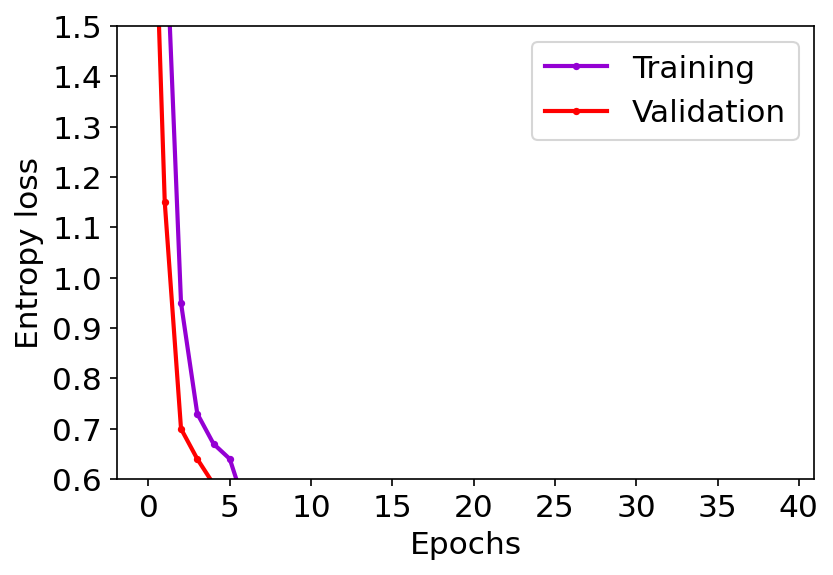

In [ ]:
epochs = list(range(len(training_stats)))
y1 = [i['training_loss'] for i in training_stats]
y2 = [i['validation_loss'] for i in training_stats]

plot(epochs, y1, y2, ymin = 0.6, ymax = 1.5, ylabel = 'Entropy loss')

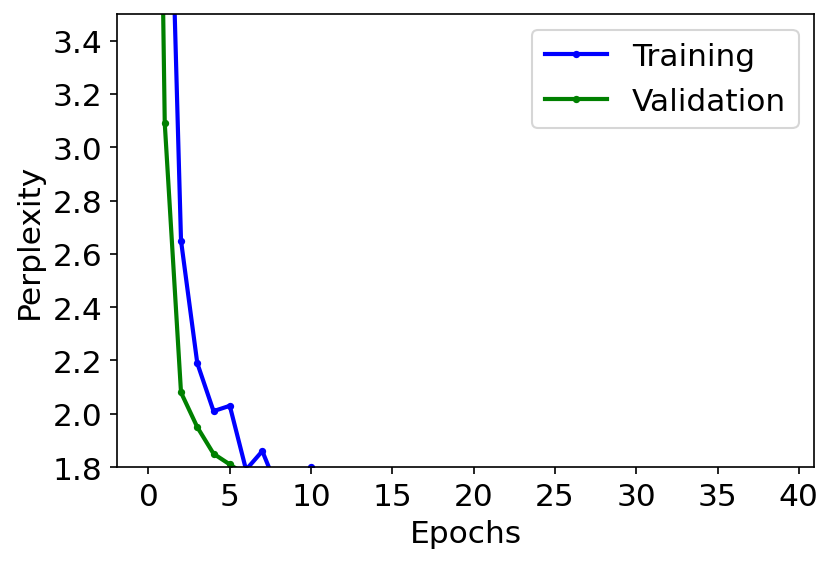

In [ ]:
epochs = list(range(len(training_stats)))
y1 = [i['training_perplexity'] for i in training_stats]
y2 = [i['validation_perplexity'] for i in training_stats]

plot(epochs, y1, y2, c1 = 'blue', c2= 'green', ymin = 1.8, ymax = 3.5, ylabel = 'Perplexity')

### Testing

In [ ]:
test_dataset = GPT2Dataset(tokenizer, train = False, val_data = test_data, clusters = finetune_clusters, centroids = finetune_centroids)
input_ids, attn_masks, val_loss_masks = val_dataset[0]
print(tokenizer.decode(input_ids))

<|endoftext|>Walk to bedroom=>Walk to floor lamp=>Switch off floor lamp
Walk to bedroom=>Walk to floor lamp=>Find floor lamp=>Turn to floor lamp=>Switch on floor lamp=>Find bed=>Lie on bed
Walk to bedroom=>Walk to dresser=>Find floor lamp=>Turn to floor lamp=>Switch on floor lamp
Walk to bedroom=>Walk to dresser=>Find floor lamp=>Turn to floor lamp=>Switch on floor lamp
Walk to bedroom=>Walk to dresser=>Find floor lamp=>Turn to floor lamp=>Switch on floor lamp
Walk to bedroom=>Walk to floor lamp=>Find floor lamp=>Turn to floor lamp=>Switch on floor lamp=>Find bed=>Lie on bed
Walk to bedroom=>Walk to dresser=>Find floor lamp=>Turn to floor lamp=>Switch on floor lamp
Walk to bedroom=>Walk to floor lamp=>Find floor lamp=>Turn to floor lamp=>Switch on floor lamp=>Find bed=>Lie on bed
Walk to bedroom=>Walk to floor lamp=>Find floor lamp=>Turn to floor lamp=>Switch on floor lamp=>Find bed=>Lie on bed
Walk to bedroom=>Walk to dresser=>Find floor lamp=>Turn to floor lamp=>Switch on floor lamp


In [ ]:
if Path(file_name).exists():
  dict_ = torch.load(file_name)
  model.load_state_dict(dict_['model'])
  # training_stats = dict_['training_stats']

Utility for decoding GPT-2 predictions

In [ ]:
dict_['training_time']

'0:00:16'

In [ ]:
dict_['validation_time']

'0:03:39'

In [ ]:
def gpt2_predict(prompt):
  # prompt = "<|endoftext|> Walk to bedroom=>Walk to floor =>"
  sample_outputs = model.generate(
                          tokenizer(prompt, return_tensors='pt')['input_ids'].cuda(),
                          bos_token_id = tokenizer.bos_token_id, #random.randint(1,30000),
                          eos_token_id = tokenizer.eos_token_id,
                          pad_token_id = tokenizer.pad_token_id,
                          do_sample=True,   
                          # temperature = 0.5,
                          # top_k=50, 
                          max_length = 100,
                          # top_p=0.95, 
                          num_return_sequences=1
                      )
  outputs = tokenizer.decode(sample_outputs[0])
  # print('outputs:', outputs)
  return outputs[len(prompt):]

In [ ]:
preds = []
trues = []

test_nlls = []
test_tokens_len = []
test_times = []

separator = '=>'
inf_times = []
for index, val_data in tqdm.tqdm(enumerate(test_dataset), total = len(test_dataset)):
  if index == 5: break
  input_ids, attn_masks, val_loss_masks = val_data
  entire_example = tokenizer.decode(input_ids).split('<|endoftext|>')[1]

  example_split = entire_example.split('\n')
  support_set = '\n'.join(example_split[:-1])
  splits = example_split[-1].split(separator)

  # code for perplexity and nll loss.
  model.train()
  encodings_dict = tokenizer(query, return_tensors = 'pt').to(device)
  outputs = model(encodings_dict['input_ids'], labels = encodings_dict['input_ids'])
  loss = outputs[0]
  len_ = encodings_dict['attention_mask'].sum()
  test_nlls.append(loss.item() * len_)
  test_tokens_len.append(len_)
  model.eval()

  time_step = np.random.randint(1, len(splits)) #len(splits)-1)

  t0 = time.time()

  for time_step in range(1, len(splits)-1):

    query = separator.join([text for text in splits[:time_step]])

    prompt = f'''<|endoftext|>{separator.join([text for text in splits[:time_step]])}=>''' #{support_set}

    # print(prompt)
    # print('####'* 10)

    t0 = time.time()
    result = gpt2_predict(prompt)
    t1 = time.time()
    inf_times.append(t1-t0)
    # print('result:', result)
    pred = result.strip().split('\n')[0].split(separator)[0].strip()
    preds.append(pred)
    trues.append(splits[time_step])

    if index <= 1:
      print(query + '=>' + pred + '\n')
    
    t1 = time.time()
    
    test_times.append(t1 - t0)

  0%|          | 0/1018 [00:00<?, ?it/s]

Walk to home office=>Walk to desk

Walk to home office=>Walk to chair=>Sit on chair

Walk to home office=>Walk to chair=>Find chair=>Grab cup

Walk to home office=>Walk to chair=>Find chair=>Sit on chair=>Lie on couch

Walk to home office=>Walk to chair=>Find chair=>Sit on chair=>Find computer=>Find chair

Walk to home office=>Walk to chair=>Find chair=>Sit on chair=>Find computer=>Switch on computer=>Greet chair

Walk to home office=>Walk to chair=>Find chair=>Sit on chair=>Find computer=>Switch on computer=>Find mouse=>Touch computer



  0%|          | 1/1018 [00:11<3:14:21, 11.47s/it]

Walk to home office=>Walk to chair=>Find chair=>Sit on chair=>Find computer=>Switch on computer=>Find mouse=>Grab mouse=>Turn to mouse

Walk to home office=>Walk to chair

Walk to home office=>Walk to laptop=>Find computer

Walk to home office=>Walk to laptop=>Find laptop=>Find phone

Walk to home office=>Walk to laptop=>Find laptop=>Grab laptop=>Grab keyboard

Walk to home office=>Walk to laptop=>Find laptop=>Grab laptop=>Find couch=>Grab television

Walk to home office=>Walk to laptop=>Find laptop=>Grab laptop=>Find couch=>Sit on couch=>Sleep for at least at night

Walk to home office=>Walk to laptop=>Find laptop=>Grab laptop=>Find couch=>Sit on couch=>Switch on laptop=>Find couch

Walk to home office=>Walk to laptop=>Find laptop=>Grab laptop=>Find couch=>Sit on couch=>Switch on laptop=>Turn to laptop=>Close laptop



  0%|          | 2/1018 [00:19<2:43:22,  9.65s/it]

Walk to home office=>Walk to laptop=>Find laptop=>Grab laptop=>Find couch=>Sit on couch=>Switch on laptop=>Turn to laptop=>Look at laptop=>Grab laptop



  0%|          | 5/1018 [00:33<1:53:07,  6.70s/it]


In [ ]:
trues = np.array(trues); preds = np.array(preds)
res = cosine_sim(trues, preds)
res = torch.stack([res[i][i] for i in range(len(res))])
correct = res> 0.5
acc = correct.sum() / len(res)
cos_sim = res.sum() / len(res)

avg_test_entropy = torch.stack(test_nlls).sum() / sum(test_tokens_len)
test_pp = torch.exp(avg_test_entropy)

df = pd.DataFrame({
    'Actual': trues,
    'Predicted': preds,
    'Cosine Sim': res,
    'Correct/not': correct
})

# Train perplexity

print(f'Accuracy is: {acc * 100}%')
print(f'Perplexity is: {test_pp}')
print(f'Avg Loss is: {avg_test_entropy}')
print(f'Cosine Similarity is: {df["Cosine Sim"].mean()}')
df

Accuracy is: 41.43712615966797%
Perplexity is: 3.985548973083496
Avg Loss is: 1.382675051689148
Cosine Similarity is: 0.46324053406715393


,Actual,Predicted,Cosine Sim,Correct/not
0,Walk to computer,Walk to desk,0.689774,True
1,Find computer,Grab remote control,0.270291,False
2,Turn to computer,Find keyboard,0.360294,False
3,Look at computer,Switch on television,0.302485,False
4,Walk to computer,Find mouse,0.337771,False
...,...,...,...,...
830,Switch on television,Scrub remote control,0.225711,False
831,Find couch,Find remote control,0.347601,False
832,Turn to couch,Sit on television,0.537342,True
833,Sit on couch,Watch television,0.493265,False


In [ ]:
model.eval()

prompt = "<|startoftext|> Walk to bedroom=>Walk to floor =>"
sample_outputs = model.generate(
                        tokenizer(prompt, return_tensors='pt')['input_ids'].cuda(),
                        bos_token_id = tokenizer.bos_token_id, #random.randint(1,30000),
                        eos_token_id = tokenizer.eos_token_id,
                        pad_token_id = tokenizer.pad_token_id,
                        do_sample=True,   
                        # temperature = 0.5,
                        # top_k=50, 
                        max_length = 30,
                        # top_p=0.95, 
                        num_return_sequences=1
                    )
outputs = tokenizer.decode(sample_outputs[0])
outputs[len(prompt):].split(separator)